In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable


torch.set_default_tensor_type(torch.DoubleTensor)

%matplotlib inline

In [3]:
## doesn't work yet; but maybe need not to..
class soft_exponential_learnable(torch.nn.Module):
    
    # centered at a
    def __init__(self, H):
        super(soft_exponential, self).__init__()
        
        alpha = torch.zeros(H).reshape(1, H)

        #torch.nn.init.xavier_uniform_(alpha)
        
        
        
        self.alpha = nn.Parameter(alpha)

        self.H = H
        
    def forward(self, x):
        
        batch_size = x.size()[0]
        ALPHA = self.alpha.expand(batch_size, -1).clone()
        less_than_zero = ALPHA<0
        greater_than_zero = ALPHA>0
        x_result = x.clone()
        
        ALPHA_L = ALPHA[less_than_zero]
        
        epsilon_l = -1e-6
        x_result[less_than_zero] = torch.max(-torch.log(1- ALPHA_L*(x[less_than_zero]+ALPHA_L))/ALPHA_L, ALPHA_L.new(ALPHA_L.shape).fill_(epsilon_l))

        ALPHA_G = ALPHA[greater_than_zero]
        
        epsilon_u = 10e2
        x_result[greater_than_zero] = torch.min(1/ALPHA_G * (torch.exp(ALPHA_G * x[greater_than_zero]) - 1) + ALPHA_G, ALPHA_G.new(ALPHA_G.shape).fill_(epsilon_u))
        
        return x_result


In [4]:
class soft_exponential(torch.nn.Module):

    def __init__(self, alpha = 0):
        super(soft_exponential, self).__init__()
        
        #alpha = torch.Tensor([alpha])
                
        self.alpha = alpha#nn.Parameter(alpha)
    
    def forward(self, x):
        if(self.alpha<0):
            return -torch.log(1-self.alpha*(x+self.alpha))/self.alpha
        elif(self.alpha==0):
            return x
        else:
            return (torch.exp(self.alpha*x) - 1)/self.alpha + self.alpha


In [5]:
def generate_data_positive(n = 100):
    x = np.random.uniform(low = -4, high = 0, size = n)
    y = np.random.uniform(low = -4, high = 0, size = n)
    t = np.array([0.1] * n)
    z = - x * (y**2) * t +  x**2 * (y) * (t**2) 
    return x, y, t, z


In [45]:
def generate_data(n = 100):
    
    x = np.random.uniform(low = 0, high = 4, size = n)
    y = np.random.uniform(low = 0, high = 4, size = n)
    t = np.random.uniform(low = 0, high = 1, size = n)
    
    z = - x * (y**2) * t +  x** 4 * (y) * (t**2) +x**3 * y**3 * t**3
    return x, y, t, z


In [14]:
def generate_test_data(n = 100):
    x = np.random.uniform(low = 4, high = 5, size = n)
    y = np.random.uniform(low = 4, high = 5, size = n)
    t = np.random.uniform(low = 0, high = 1, size = n)
    
    z = - x * (y**2) * t +  x** 4 * (y) * (t**2) +x**3 * y**3 * t**3
    return x, y, t, z


In [15]:
class MultiplicationNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MultiplicationNet, self).__init__()
        
        self.log = soft_exponential(-1)
        
        self.input = nn.Linear(H, D_in, bias = False)
        
        self.input.weight = nn.Parameter(torch.randint(0,5,( H, D_in)).double())
        
        #self.input = nn.Linear(D_in, H, bias = False)
        
        self.exp = soft_exponential(1)
        
        self.out = nn.Linear(H, D_out, bias = False)
        
        self.out.weight = nn.Parameter(torch.ones((D_out, H)).double())
        

    def forward(self, X):
        X = self.log(X)
        X = self.input(X)
        X = self.exp(X)

        X = self.out(X)
        return X

In [30]:
class MultiplicationNet_skip(torch.nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(MultiplicationNet_skip, self).__init__()
        
        #self.input0 = nn.Linear(D_in, D_in)
        
        self.log = soft_exponential(-1)
        
        self.input = nn.Linear(D_in, H, bias = False)
        self.input.weight = nn.Parameter(torch.randint(0,4,(H, D_in)).double())
        
        self.exp = soft_exponential(1)
        
        self.h1 = nn.Linear(H, D_in, bias = False)
        self.h1.weight = nn.Parameter(torch.ones((D_in, H)).double())
        
        self.h2 = nn.Linear((D_in *2), (D_in *2))

        self.out = nn.Linear((D_in *2), D_out)
        

    def forward(self, X):
        
        #X = self.input0(X)
        
        X1 = X
        ## SKIP ##
        ###### multiplication block #####
        X = self.log(torch.FloatTensor.abs_(X))

        X = self.input(X)
        
        X = self.exp(X)
        ###### multiplication block #####
        X = self.h1(torch.relu(X))

        X = torch.cat((X, X1), 1)
        
        X = torch.relu(self.h2(X))
        
        X = self.out(X)
        
        return X

In [17]:
class FFNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(FFNet, self).__init__()
                
        self.input = nn.Linear(D_in,H)
        
        self.h1 = nn.Linear(H,H)
        self.h2 = nn.Linear(H,H)
                                
        self.out = nn.Linear(H, D_out)
                

    def forward(self, X):
        X = torch.relu(self.input(X))
        X = torch.relu(self.h1(X))
        X = self.h2(X)
        X = self.out(X)
        return X

In [46]:
num_epochs = 200000
n_train = 300
batch_size = 30
learning_rate = 1e-4

In [47]:
model = MultiplicationNet(3, 16, 1)
#model = FFNet(3,32,1)
MSE= nn.MSELoss()

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=5*learning_rate, weight_decay=1e-5)

In [48]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

input.weight tensor([[0., 0., 3.],
        [0., 3., 4.],
        [4., 2., 4.],
        [4., 4., 2.],
        [1., 3., 1.],
        [1., 1., 3.],
        [3., 1., 3.],
        [3., 1., 2.],
        [1., 3., 2.],
        [3., 1., 2.],
        [3., 0., 3.],
        [0., 1., 1.],
        [2., 4., 2.],
        [1., 0., 2.],
        [0., 0., 3.],
        [2., 1., 4.]])
out.weight tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [62]:
loss_datas = []
for epoch in range(num_epochs):
    xx,yy,tt,zz = generate_data(n_train)
    X = torch.Tensor(np.vstack((xx,yy,tt)).T)
    y = torch.Tensor(zz.reshape(-1,1))
    for i in range(int(len(X)/batch_size)):
        Xi = X[i*batch_size:(i+1)*batch_size]
        yi = y[i*batch_size:(i+1)*batch_size]
        # forward
        output = model(Xi)
        loss = MSE(output, yi) + model.out.weight.norm(1) * (MSE(output,yi).data/model.out.weight.norm(1).data) # L1 regularization
        loss_datas.append(loss.data)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if( (epoch+1) % int(num_epochs/10) ==0):
        print('epoch [{}/{}], loss:{:.12f}'.format(epoch + 1, num_epochs, loss.data))
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(name, param.data, param.data.grad)

epoch [20000/200000], loss:0.005600497184
input.weight tensor([[-0.4025, -0.3470,  0.4789],
        [ 2.1051,  0.4703,  1.7750],
        [ 3.3301,  1.6379,  2.7352],
        [ 3.1416,  3.0405,  2.9783],
        [ 0.9749,  2.1009,  0.9707],
        [-0.4259, -0.3525,  0.4794],
        [ 2.4913,  0.5675,  3.0960],
        [ 3.9173,  0.9528,  1.9656],
        [ 1.6791,  2.9993,  3.0581],
        [ 3.9173,  0.9528,  1.9656],
        [ 2.8232,  1.1862,  2.7147],
        [ 1.5348,  1.2391,  1.3486],
        [ 2.4664,  2.9712,  3.0679],
        [ 2.7731,  0.5419,  1.6973],
        [-0.4025, -0.3470,  0.4789],
        [-0.4079, -0.3503,  0.4614]]) None
out.weight tensor([[-1.4684e-04,  5.5898e-01,  2.7223e-01,  5.7857e-01, -7.7356e-01,
         -2.3864e-04,  4.9209e-02,  5.8457e-01, -1.7257e-01,  5.8457e-01,
         -4.3494e-01, -3.0401e-01,  5.6576e-01, -5.0780e-01, -1.4684e-04,
         -2.7771e-04]]) None
epoch [40000/200000], loss:0.013194807690
input.weight tensor([[-0.3592, -0.3818,  0.

In [63]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data, param.data.grad)

input.weight tensor([[-0.4240, -0.4091,  0.4962],
        [-0.4311, -0.4256,  0.4755],
        [-0.4487, -0.4709,  0.4061],
        [ 3.0841,  3.0121,  2.9971],
        [ 1.0130,  2.0284,  0.9863],
        [-0.1292, -0.1441,  0.2621],
        [-0.0909, -0.1411,  0.3224],
        [ 4.0010,  0.9991,  2.0001],
        [ 1.1730,  2.3558,  2.3367],
        [ 4.0010,  0.9991,  2.0001],
        [ 0.0811,  0.0315,  0.2214],
        [-0.2584, -0.2448,  0.3975],
        [ 2.7561,  2.9584,  2.9966],
        [ 0.0322, -0.0950,  0.3472],
        [-0.4240, -0.4091,  0.4962],
        [-0.4046, -0.3908,  0.5188]]) None
out.weight tensor([[ 2.1020e-04,  4.2132e-04,  1.0798e-03,  6.4674e-01, -9.2105e-01,
         -3.1264e-03, -3.8271e-03,  4.9885e-01, -9.8899e-02,  4.9885e-01,
         -4.3537e-03, -9.4984e-04,  3.9288e-01, -3.3222e-03,  2.1020e-04,
          1.6092e-04]]) None


In [960]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print(get_n_params(model_FF))
print(get_n_params(model_skip))

2273
433


In [954]:
def test_vs_train_data(model):
    xx,yy,tt,zz = generate_test_data(n_train)
    X = torch.Tensor(np.vstack((xx,yy,tt)).T)
    y = torch.Tensor(zz.reshape(-1,1))

    # forward
    output = model(X)
    loss1 = MSE(output, y)
    
    xx,yy,tt,zz = generate_data(n_train)
    X = torch.Tensor(np.vstack((xx,yy,tt)).T)
    y = torch.Tensor(zz.reshape(-1,1))

    # forward
    output = model(X)
    loss2 = MSE(output, y)

    print('test: '+str(loss1.data))
    print('train: '+str(loss2.data))

test_vs_train_data(model_FF)

test_vs_train_data(model_skip)

test: tensor(17.0362)
train: tensor(0.0001)
test: tensor(0.1459)
train: tensor(0.0007)


In [950]:
loss_data_FF = loss_datas

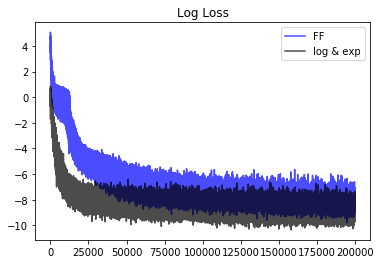

In [962]:
# Multiplication Net parameters = 30 + 10 = 40

plt.title('Log Loss')
plt.plot(np.log(loss_data_skip[:]),color = 'b',alpha = 0.7, label = 'FF')

# FF model parameters = 30 + 10 + 100 + 10 + 10 + 1 = 161
plt.plot(np.log(loss_data_FF[:]),color = 'k',alpha = 0.7, label = 'log & exp')

# skip model parameters = 30 + 30 + 7 = 67
#plt.plot(np.log(loss_data_skip[:]),color = 'r',alpha = 0.7)
plt.legend()



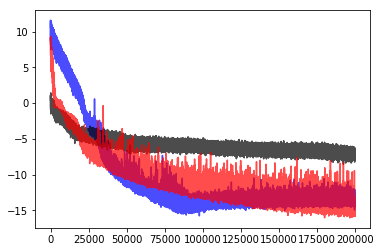

In [557]:
# Multiplication Net parameters = 30 + 10 = 40

plt.plot(np.log(loss_data_non_skip[:]),color = 'b',alpha = 0.7)

# FF model parameters = 30 + 10 + 100 + 10 + 10 + 1 = 161
plt.plot(np.log(loss_data_FF[:]),color = 'k',alpha = 0.7)

# skip model parameters = 30 + 30 + 7 = 67
plt.plot(np.log(loss_data_skip[:]),color = 'r',alpha = 0.7)
